In [1]:
import sys
import os

import numpy as np

import scipy.io
from matplotlib import pyplot as plt

import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import DataLoader, random_split
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same"),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same"),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.AvgPool2d(kernel_size=(2,2))

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up   = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [2]:
class u_net(nn.Module):
    def __init__(self, in_channels, feat):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels,   feat)
        self.down_convolution_2 = DownSample(    feat,  2 * feat)
        self.down_convolution_3 = DownSample(2 * feat,  4 * feat)
        self.down_convolution_4 = DownSample(4 * feat,  8 * feat)

        self.bottle_neck        = DoubleConv(8 * feat, 16 * feat)

        self.up_convolution_1 = UpSample(16 * feat + 8 * feat,  8 * feat)
        self.up_convolution_2 = UpSample(8  * feat + 4 * feat,  4 * feat)
        self.up_convolution_3 = UpSample(4  * feat + 2 * feat,  2 * feat)
        self.up_convolution_4 = UpSample(2  * feat +     feat,      feat)

        # Sigmoid to convert the numerics
        self.out = nn.Conv2d(in_channels=feat, out_channels=1, kernel_size=1)
        self.sig =nn.Sigmoid()

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
       
        return self.sig(out)

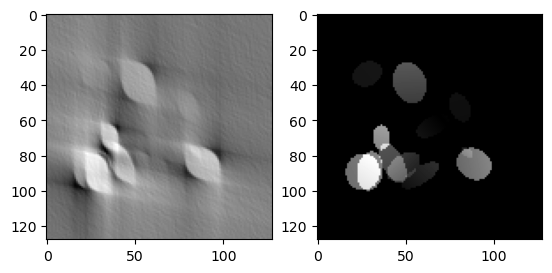

In [3]:
# Path to the folder containing .mat files

ANGLE = "80" # "120", "100", "80"

x_folder_path = 'train/XImages'+ANGLE
y_folder_path = 'train/Images'

# List all .mat files in the folder
x_mat_files = sorted([f for f in os.listdir(x_folder_path) if f.endswith('.mat')])
y_mat_files = sorted([f for f in os.listdir(y_folder_path) if f.endswith('.mat')])

x_train_list = []  # list of true images
y_train_list = []  # list of artifact images
sample_size = 10000
for i in range(sample_size):
    x_mat = scipy.io.loadmat(os.path.join(x_folder_path, x_mat_files[i]))
#     print(x_mat)
    x_train = x_mat['P']
    x_train_list.append(x_train)
    
    y_mat = scipy.io.loadmat(os.path.join(y_folder_path, y_mat_files[i]))
    y_train = y_mat['im_reduced']
    y_train_list.append(y_train)

x_train_full = np.array(x_train_list)
y_train_full = np.array(y_train_list)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.imshow(x_train_full[1],cmap='gray') 
ax = fig.add_subplot(1, 2, 2)
plt.imshow(y_train_full[1],cmap='gray')



In [4]:
# training data

xdata = x_train_full[:5000]
ydata = y_train_full[:5000]

test_xdata = x_train_full[5000::]
test_ydata = y_train_full[5000::]

In [5]:
from torch.utils.data.dataset import Dataset

class CT_Dataset(Dataset):
    def __init__(self, xdata, ydata):
        self.xdata = torch.tensor(xdata).unsqueeze(dim=1)
        self.ydata = torch.tensor(ydata).unsqueeze(dim=1)
        
    def __getitem__(self, index):
        x_img = self.xdata[index]
        y_img = self.ydata[index]

        return x_img, y_img

    def __len__(self):
        return len(self.xdata)

In [6]:
BATCH_SIZE = 50

train_dataset = CT_Dataset(xdata, ydata)
test_dataset = CT_Dataset(test_xdata, test_ydata)

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

train_dataloader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

In [7]:
LEARNING_RATE = 1e-3

EPOCHS = 200


MODEL_SAVE_PATH = "./ct_model_unet_" + ANGLE +".pth"

device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
model = u_net(in_channels=1, feat=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
criterion = nn.MSELoss()

In [9]:
import time

history = {'train_loss': [], 'val_loss': []}
best_val_loss = None

for epoch in range(EPOCHS):
    tic = time.time()
    model.train()
    train_running_loss = 0
    for idx, xydata in enumerate((train_dataloader)):
        _xdata = xydata[0].float().to(device)
        _ydata = xydata[1].float().to(device)

        y_pred = model(_xdata)
        optimizer.zero_grad()

        loss = criterion(y_pred, _ydata)
        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    
    scheduler.step()
    
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for idx, xydata in enumerate(val_dataloader):
            _xdata = xydata[0].float().to(device)
            _ydata = xydata[1].float().to(device)

            y_pred = model(_xdata)
            loss = criterion(y_pred, _ydata)

            val_running_loss += loss.item()
        val_loss = val_running_loss / (idx + 1)

    elapse = time.time() - tic
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    if best_val_loss is None or val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best-model-parameters-'+ANGLE+'.pt') # official recommended
        best_val_loss = val_loss
    
    print(f"Train Loss EPOCH {(epoch+1):6d}: {train_loss:6.4e} | Valid Loss EPOCH {(epoch+1):6d}: {val_loss:6.4e} | time: {elapse: 6.4f}")

torch.save(model.state_dict(), MODEL_SAVE_PATH)

Train Loss EPOCH      1: 8.3401e-02 | Valid Loss EPOCH      1: 4.5374e-02 | time:  8.3781
Train Loss EPOCH      2: 2.6055e-02 | Valid Loss EPOCH      2: 1.3156e-02 | time:  8.0616
Train Loss EPOCH      3: 1.2929e-02 | Valid Loss EPOCH      3: 7.3296e-03 | time:  8.0973
Train Loss EPOCH      4: 8.9118e-03 | Valid Loss EPOCH      4: 5.4432e-03 | time:  8.1220
Train Loss EPOCH      5: 9.5208e-03 | Valid Loss EPOCH      5: 9.5983e-03 | time:  8.1415
Train Loss EPOCH      6: 6.5671e-03 | Valid Loss EPOCH      6: 4.9134e-03 | time:  8.1786
Train Loss EPOCH      7: 4.5359e-03 | Valid Loss EPOCH      7: 3.6919e-03 | time:  8.1981
Train Loss EPOCH      8: 4.0035e-03 | Valid Loss EPOCH      8: 3.1523e-03 | time:  8.2260
Train Loss EPOCH      9: 3.2031e-03 | Valid Loss EPOCH      9: 2.7721e-03 | time:  8.2501
Train Loss EPOCH     10: 2.7842e-03 | Valid Loss EPOCH     10: 2.4776e-03 | time:  8.2620
Train Loss EPOCH     11: 2.5921e-03 | Valid Loss EPOCH     11: 2.2712e-03 | time:  8.2746
Train Loss

Train Loss EPOCH     93: 1.0913e-03 | Valid Loss EPOCH     93: 1.5705e-03 | time:  8.3368
Train Loss EPOCH     94: 1.1754e-03 | Valid Loss EPOCH     94: 1.3776e-03 | time:  8.3350
Train Loss EPOCH     95: 1.0000e-03 | Valid Loss EPOCH     95: 1.4369e-03 | time:  8.3353
Train Loss EPOCH     96: 9.6112e-04 | Valid Loss EPOCH     96: 1.3554e-03 | time:  8.3343
Train Loss EPOCH     97: 9.5449e-04 | Valid Loss EPOCH     97: 1.3455e-03 | time:  8.3357
Train Loss EPOCH     98: 9.6871e-04 | Valid Loss EPOCH     98: 1.5566e-03 | time:  8.3360
Train Loss EPOCH     99: 9.4993e-04 | Valid Loss EPOCH     99: 1.3543e-03 | time:  8.3349
Train Loss EPOCH    100: 9.1976e-04 | Valid Loss EPOCH    100: 1.4422e-03 | time:  8.3338
Train Loss EPOCH    101: 8.9252e-04 | Valid Loss EPOCH    101: 1.3775e-03 | time:  8.3328
Train Loss EPOCH    102: 8.6016e-04 | Valid Loss EPOCH    102: 1.3854e-03 | time:  8.3304
Train Loss EPOCH    103: 8.4454e-04 | Valid Loss EPOCH    103: 1.4393e-03 | time:  8.3332
Train Loss

Train Loss EPOCH    185: 5.7275e-04 | Valid Loss EPOCH    185: 1.4959e-03 | time:  8.3400
Train Loss EPOCH    186: 5.5861e-04 | Valid Loss EPOCH    186: 1.7467e-03 | time:  8.3380
Train Loss EPOCH    187: 5.6914e-04 | Valid Loss EPOCH    187: 1.6454e-03 | time:  8.3370
Train Loss EPOCH    188: 5.5745e-04 | Valid Loss EPOCH    188: 1.4072e-03 | time:  8.3376
Train Loss EPOCH    189: 5.5735e-04 | Valid Loss EPOCH    189: 1.3986e-03 | time:  8.3375
Train Loss EPOCH    190: 5.5014e-04 | Valid Loss EPOCH    190: 1.3754e-03 | time:  8.3425
Train Loss EPOCH    191: 5.3911e-04 | Valid Loss EPOCH    191: 1.4408e-03 | time:  8.3432
Train Loss EPOCH    192: 5.3399e-04 | Valid Loss EPOCH    192: 1.4392e-03 | time:  8.3379
Train Loss EPOCH    193: 5.2908e-04 | Valid Loss EPOCH    193: 1.3777e-03 | time:  8.3388
Train Loss EPOCH    194: 5.2657e-04 | Valid Loss EPOCH    194: 1.3911e-03 | time:  8.3360
Train Loss EPOCH    195: 5.4237e-04 | Valid Loss EPOCH    195: 1.4186e-03 | time:  8.3385
Train Loss

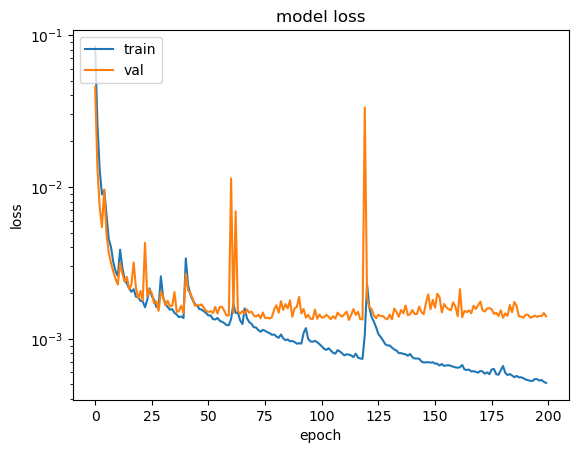

In [10]:
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log',base=10) 
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
model.load_state_dict(torch.load('./best-model-parameters-'+ANGLE+'.pt'), strict=True)
model.eval()

val_running_loss = 0

with torch.no_grad():

    for idx, xydata in enumerate(test_dataloader):
        _xdata = xydata[0].float().to(device)
        _ydata = xydata[1].float().to(device)

        y_pred = model(_xdata)
        loss = criterion(y_pred, _ydata)

        val_running_loss += loss.item()
        val_loss = val_running_loss / (idx + 1)

    print(val_loss)

0.0014463920600246637


In [12]:
# TEST MSE

# 120 degrees :  0.0005778832914074883 (best)
# 100 degress :  0.0009710367600200698 (best)
# 80  degrees :  0.0013324491132516414 (best)